In [1]:
import torch
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [39]:
dataset = CIFAR10(root='data/',download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/',train=False , transform=ToTensor())

Files already downloaded and verified


In [3]:
dataset_size = len(dataset)
dataset_size

50000

In [40]:
test_dataset_size = len(test_dataset)
test_dataset_size

10000

In [5]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
num_classes = len(classes)
num_classes

10

In [7]:
img , label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Label (numeric): 6
Label (textual): frog


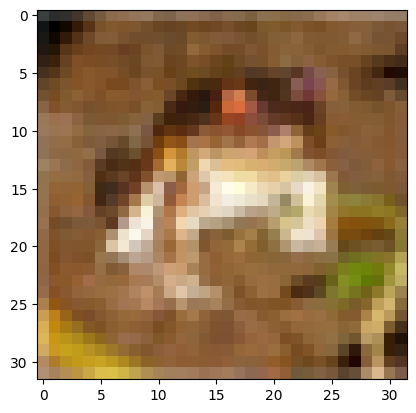

In [8]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [9]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

In [10]:
train_ds , val_ds = random_split(dataset , [train_size,val_size])
len(train_ds) , len(val_ds)

(45000, 5000)

In [11]:
batch_size = 128

In [41]:
train_loader = DataLoader(train_ds , batch_size , shuffle=True, num_workers =  5, pin_memory=True)
test_loader = DataLoader(test_dataset , batch_size*2 ,  num_workers= 5 , pin_memory= True)
val_loader = DataLoader(val_ds , batch_size*2 , num_workers= 5 , pin_memory= True)

In [13]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [35]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [16]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
torch.cuda.is_available()

True

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [22]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [42]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [24]:
input_size = 3*32*32
output_size = 10

In [25]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size , 1536)
        self.linear2 = nn.Linear(1536 ,768)
        self.linear3 = nn.Linear(768, 64)
        self.linear4 = nn.Linear(64 , 32)
        self.linear5 = nn.Linear(32 ,output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out

In [26]:
model = to_device(CIFAR10Model(), device)

In [27]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.309149980545044, 'val_acc': 0.09564568102359772}]

In [28]:
history += fit(15, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 2.0447, val_acc: 0.2259
Epoch [1], val_loss: 1.8373, val_acc: 0.3352
Epoch [2], val_loss: 1.7762, val_acc: 0.3598
Epoch [3], val_loss: 1.7705, val_acc: 0.3631
Epoch [4], val_loss: 1.7760, val_acc: 0.3658
Epoch [5], val_loss: 1.7133, val_acc: 0.3880
Epoch [6], val_loss: 1.6345, val_acc: 0.4102
Epoch [7], val_loss: 1.5868, val_acc: 0.4359
Epoch [8], val_loss: 1.5528, val_acc: 0.4381
Epoch [9], val_loss: 1.5811, val_acc: 0.4329
Epoch [10], val_loss: 1.5419, val_acc: 0.4426
Epoch [11], val_loss: 1.5535, val_acc: 0.4353
Epoch [12], val_loss: 1.5147, val_acc: 0.4696
Epoch [13], val_loss: 1.4455, val_acc: 0.4916
Epoch [14], val_loss: 1.5223, val_acc: 0.4589


In [29]:
history += fit(5, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 1.4088, val_acc: 0.5011
Epoch [1], val_loss: 1.4436, val_acc: 0.4835
Epoch [2], val_loss: 1.3788, val_acc: 0.5109
Epoch [3], val_loss: 1.4227, val_acc: 0.4984
Epoch [4], val_loss: 1.3605, val_acc: 0.5232


In [30]:
history += fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.3183, val_acc: 0.5430
Epoch [1], val_loss: 1.3348, val_acc: 0.5430
Epoch [2], val_loss: 1.3326, val_acc: 0.5416
Epoch [3], val_loss: 1.3457, val_acc: 0.5451
Epoch [4], val_loss: 1.3437, val_acc: 0.5436


In [31]:
history += fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.3240, val_acc: 0.5516
Epoch [1], val_loss: 1.3231, val_acc: 0.5524
Epoch [2], val_loss: 1.3244, val_acc: 0.5520
Epoch [3], val_loss: 1.3236, val_acc: 0.5570
Epoch [4], val_loss: 1.3266, val_acc: 0.5555


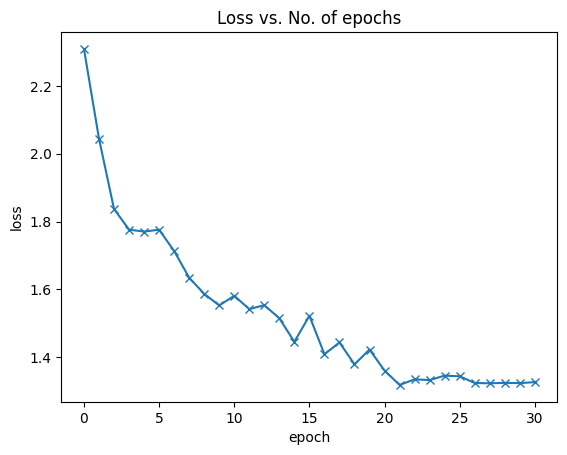

In [32]:
plot_losses(history)

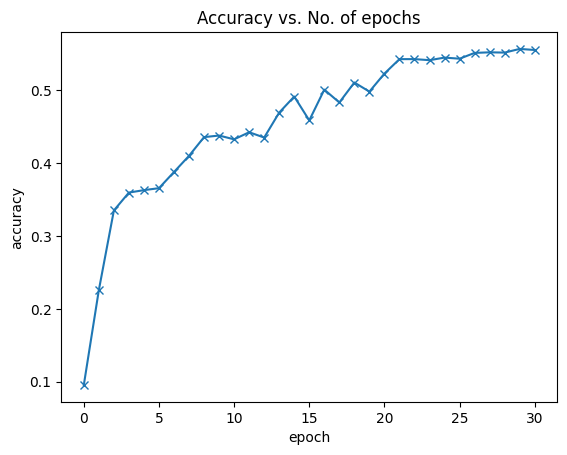

In [33]:
plot_accuracies(history)

In [37]:
evaluate(model, val_loader)

{'val_loss': 1.326561450958252, 'val_acc': 0.555549144744873}

In [43]:
evaluate(model,test_loader)

{'val_loss': 1.2674928903579712, 'val_acc': 0.560253918170929}